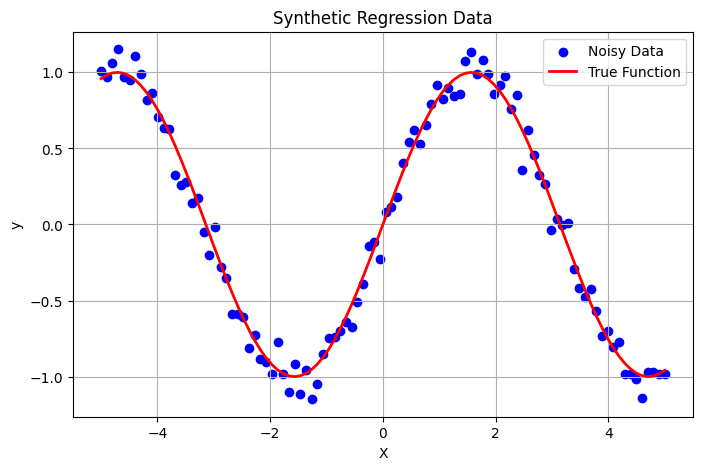

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic regression data
np.random.seed(42)
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(X) + 0.1 * np.random.randn(100, 1)  # y = sin(X) with some noise

# Plot the data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label='Noisy Data')  # Scatter plot
plt.plot(X, np.sin(X), color='red', linewidth=2, label='True Function')  # True sin(X)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Regression Data")
plt.legend()
plt.grid()
plt.show()

In [16]:
print(X.shape)
print(y.shape)
print(X[5])
print(y[5])


(100, 1)
(100, 1)
[-4.49494949]
[0.95303933]


In [ ]:
# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input ones, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


In [ ]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let’s make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [ ]:
import numpy as np

# Adam optimizer
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first pass and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [ ]:
# import numpy as np

# Create dataset
# X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(1, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 1)

# Create Softmax classifier's combined loss and activation
# loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

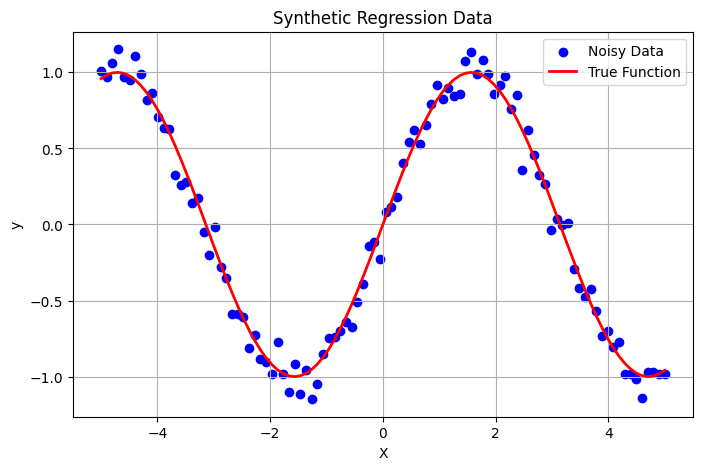

epoch: 0, loss: 0.56062, lr: 0.02000
epoch: 1000, loss: 0.01546, lr: 0.01980
epoch: 2000, loss: 0.00788, lr: 0.01961
epoch: 3000, loss: 0.00741, lr: 0.01942
epoch: 4000, loss: 0.00700, lr: 0.01923
epoch: 5000, loss: 0.00749, lr: 0.01905
epoch: 6000, loss: 0.00691, lr: 0.01887
epoch: 7000, loss: 0.00935, lr: 0.01869
epoch: 8000, loss: 0.00724, lr: 0.01852
epoch: 9000, loss: 0.00789, lr: 0.01835
epoch: 10000, loss: 0.00687, lr: 0.01818


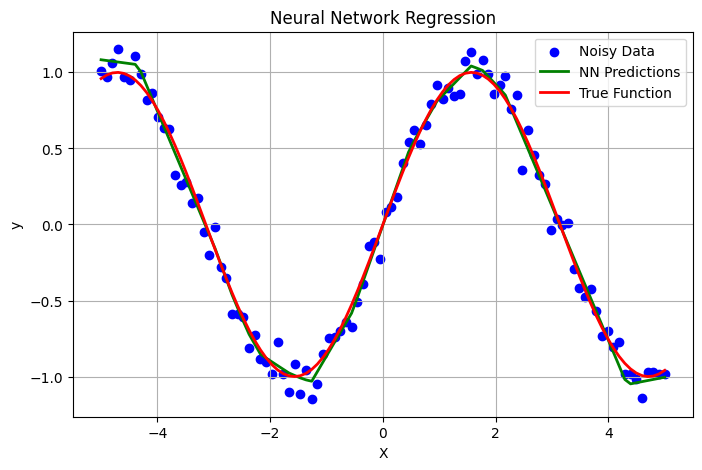

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic regression data
np.random.seed(42)
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(X) + 0.1 * np.random.randn(100, 1)  # y = sin(X) with some noise

# Plot the data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label='Noisy Data')  # Scatter plot
plt.plot(X, np.sin(X), color='red', linewidth=2, label='True Function')  # True sin(X)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Regression Data")
plt.legend()
plt.grid()
plt.show()

# Dense layer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

# ReLU activation
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

# Mean Squared Error (MSE) Loss
class Loss_MSE:
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2)

    def backward(self, y_pred, y_true):
        samples = len(y_true)
        self.dinputs = -2 * (y_true - y_pred) / samples

# Adam optimizer
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

# Model architecture
dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 1)  # Linear activation for regression
loss_function = Loss_MSE()
optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

# Training loop
epochs = 10001
for epoch in range(epochs):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    
    # Compute loss
    loss = loss_function.forward(dense2.output, y)
    
    # Print updates
    if epoch % 1000 == 0:
        print(f'epoch: {epoch}, loss: {loss:.5f}, lr: {optimizer.current_learning_rate:.5f}')
    
    # Backward pass
    loss_function.backward(dense2.output, y)
    dense2.backward(loss_function.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update parameters
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# Plot predictions
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label='Noisy Data')  # Original data
plt.plot(X, dense2.output, color='green', linewidth=2, label='NN Predictions')  # NN predictions
plt.plot(X, np.sin(X), color='red', linewidth=2, label='True Function')  # True sin(X)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Neural Network Regression")
plt.legend()
plt.grid()
plt.show()
